題目一：
1. 請利用幣安交易所 API、OKX 交易所 API 撈出 MINAUSDT 永續期貨資金
費率的歷史資料
2. 確認資料時區一致，並整理成相同的資料格式
3. 繪製視覺化圖表與統計數據，並製作一份報告說明分析結果與你的觀察

In [257]:
import requests
from datetime import datetime, timezone, timedelta
import pandas as pd
import matplotlib.pyplot as plt

START_DATE = 1740744000000, 
END_DATE= 1740761940000  

## Binance API 相關


In [258]:
# ---------------------------
# Fetch Binance Candle Data
# ---------------------------
def fetch_binance_candle_data():
    url = 'https://api.binance.com/api/v3/klines'
    # Set the parameters
    params = {
        'symbol': 'MINAUSDT',  # Symbol for Ethereum/Tether
        'interval': '1m',     # Interval: 1 day
        'limit': 300,          # Number of data points to retrieve
        # "startTime":START_DATE,
        # "endTime":END_DATE,
        "timeZone":"+0:00"
    }
    # Make the GET request
    response = requests.get(url, params=params)
    data = response.json()
    
    # Binance returns a list of lists. Each inner list represents a candle:
    # [open_time, open, high, low, close, volume, close_time, ...]
    df = pd.DataFrame(data, columns=[
        "open_time", "open", "high", "low", "close", "volume", 
        "close_time", "quote_asset_volume", "num_trades", 
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # Convert 'close' to numeric
    df['open_time'] = pd.to_numeric(df['open_time'])
    df['close_time'] = pd.to_numeric(df['open_time'])
    
    # Convert timestamps to datetime (milliseconds to UTC)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms', utc=True)
    
    # Convert 'close' price to numeric (this will serve as our sell price)
    df['close'] = pd.to_numeric(df['close'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    
    # We will use the candle's closing time as the reference time
    df = df[['close_time', 'close', 'high', 'low',]]
    df.rename(columns={
        "close_time": "time",
        "close": "sell_price_binance",
        "high": "high_price_binance",
        "low": "low_price_binance",
        }, inplace=True)
    
    return df

fetch_binance_candle_data().head()

,time,sell_price_binance,high_price_binance,low_price_binance
0,2025-03-31 16:22:00+00:00,0.2417,0.2417,0.2415
1,2025-03-31 16:23:00+00:00,0.2417,0.2419,0.2417
2,2025-03-31 16:24:00+00:00,0.2416,0.2417,0.2416
3,2025-03-31 16:25:00+00:00,0.2416,0.2416,0.2416
4,2025-03-31 16:26:00+00:00,0.2416,0.2416,0.2416


## OKX API 相關
1. OKX API doc裡面關於startTime與endTime寫的不是很清楚，測試後實際運作與其描述得不太一樣，為避免麻煩就直接不去指定時間，直接抓取最新300個k bar，時間interval設定為1分鐘。(ref: https://www.okx.com/docs-v5/en/?python#order-book-trading-market-data-get-candlesticks)
2. 特別把爬過來的時間先從str轉成int，方便後續轉時間格式。
3. 時區都設定為UTC+0。  

In [259]:
def fetch_okx_candle_data():
    url = "https://www.okx.com/api/v5/market/candles"
    
    params= {
        "instId":"MINA-USDT-SWAP",
        "limit":300, # Number of data points to retrieve
        "bar":"1m", # Interval: 1 minute (UTC time zone)
    }
    response = requests.get(url, params=params)
    data = response.json()
    

    candles = data.get("data", [])
    # Define columns accordingly; extra fields are given a generic name
    df = pd.DataFrame(candles, columns=["time", "open", "high", "low", "close" ,"volume", "volCcy","volCcyQuote","confirm"])
    
    
    df['time'] = pd.to_numeric(df['time'])
    # Convert time to datetime. OKX returns time as a string representing milliseconds.
    df['time'] = pd.to_datetime(df['time'], unit='ms', utc=True)
    
    # Convert 'close' price to numeric (this will serve as our sell price)
    df['close'] = pd.to_numeric(df['close'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    
    # Keep only the time and close price (our sell price)
    df = df[['time', 'close', 'high', 'low']]
    df.rename(columns={
        "time": "time",
        "close": "sell_price_okx",
        "high":"high_price_okx",
        "low":"low_price_okx",
        }, inplace=True)
    
    return df

fetch_okx_candle_data().head()


,time,sell_price_okx,high_price_okx,low_price_okx
0,2025-03-31 21:21:00+00:00,0.2380,0.2380,0.2380
1,2025-03-31 21:20:00+00:00,0.2380,0.2382,0.2380
2,2025-03-31 21:19:00+00:00,0.2382,0.2382,0.2382
3,2025-03-31 21:18:00+00:00,0.2382,0.2383,0.2382
4,2025-03-31 21:17:00+00:00,0.2383,0.2383,0.2382


In [260]:
# Fetch data from both exchanges
df_binance = fetch_binance_candle_data()
df_okx = fetch_okx_candle_data()

# Set the time column as the DataFrame index for easier merging and plotting
df_binance.set_index("time", inplace=True)
df_okx.set_index("time", inplace=True)

# Merge the two datasets on their datetime index
merged_df = pd.merge(df_binance, df_okx, left_index=True, right_index=True, how="outer")
merged_df.sort_index(inplace=True)
merged_df['difference']= (merged_df['sell_price_okx'] - merged_df['sell_price_binance'])/merged_df['sell_price_binance'] * 100


# 視覺化圖表與統計數據 & 分析結果
下圖表是根據執行程式的當下回推6小時的資料，因此出來的結果可能會與我現在的不同。
由下圖表可以發現:
1. 幣安與OKX之間存在價差，其中圖二(下面那張是以幣安為底，(okx-binance) / binance *100 )可以看到價差多在 0至0.1%之間浮動，最大時達到0.3%。
2. 以套利來說，我認為這個潛在獲利率是滿大的，要是能以大一點的槓桿(用閃電貸或是開槓桿)，可以獲得滿大的獲利。
3. 因為下圖的interval是1分鐘，若能取得更小的間隔data，能獲得更多有用的資訊。
4. 呈上點，當資料量大後，可以用機器學習去偵測是否有甚麼pattern可以去依循，例如OKX總會慢幣安多久才會反映價格，若有此情形就可以去套利。
5. 此外在價格波動圖中可以發現，有些價差區間是存在很久的(1-2分鐘)，以目測來看在5小時內就有11處，我認為可以出現的次數相較的高，因此可以嘗試分析pattern去套利。

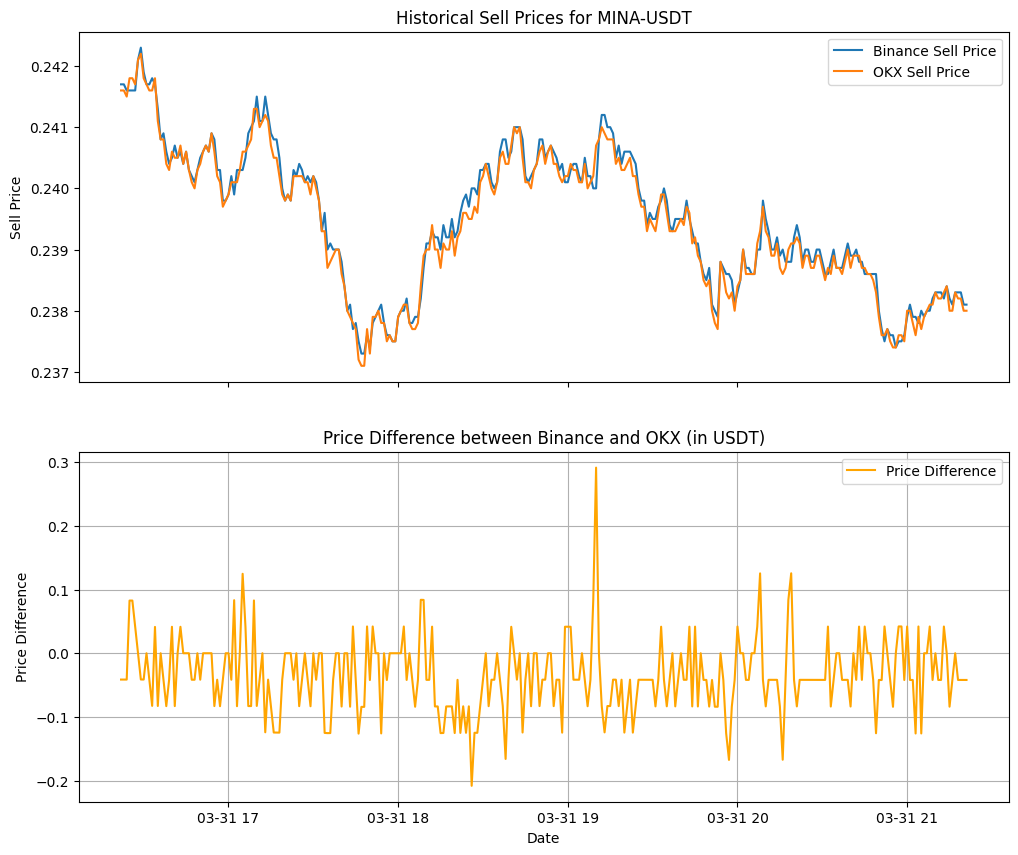

In [261]:

# Visualize the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax1.plot(merged_df.index, merged_df["sell_price_binance"], label="Binance Sell Price")
ax1.plot(merged_df.index, merged_df["sell_price_okx"], label="OKX Sell Price")
ax1.set_ylabel("Sell Price")
ax1.set_title("Historical Sell Prices for MINA-USDT")
ax1.legend()

ax2.plot(merged_df.index, merged_df["difference"], label="Price Difference", color='orange')
ax2.set_ylabel("Price Difference")
ax2.set_xlabel("Date")
ax2.set_title("Price Difference between Binance and OKX (in USDT)")

plt.legend()
plt.grid(True)
plt.show()




